In [35]:
import sqlite3
import json
import yaml
from datetime import datetime
import shutil
import pandas as pd
from pathlib import Path
from typing import Dict, List, Union, Any, Optional, Tuple
import uuid
import uproot
import numpy as np
from tqdm import tqdm
import requests
import tensorflow as tf
from abc import ABC, abstractmethod
from tensorflow import keras
from qkeras import QDense, QActivation, quantized_bits, quantized_relu
import platform
import os
import matplotlib.pyplot as plt
import psutil
import time

In [2]:
class ModelRegistry:
    """
    Enhanced central registry for managing ML experiments, models, and metrics
    Tracks detailed dataset configurations and training metrics
    """
    def __init__(self, base_path: str):
        self.base_path = Path(base_path)
        self.db_path = self.base_path / "registry.db"
        self.model_store = self.base_path / "model_store"
        
        # Create directories if they don't exist
        self.model_store.mkdir(parents=True, exist_ok=True)
        
        # Initialize database
        self._initialize_db()
        
    def _initialize_db(self):
        """Create database tables if they don't exist"""
        with sqlite3.connect(self.db_path) as conn:
            # Main experiments table
            conn.execute("""
                CREATE TABLE IF NOT EXISTS experiments (
                    experiment_id TEXT PRIMARY KEY,
                    timestamp DATETIME,
                    name TEXT,
                    description TEXT,
                    status TEXT,
                    environment_info JSON
                )
            """)
            
            # Dataset configuration table
            conn.execute("""
                CREATE TABLE IF NOT EXISTS dataset_configs (
                    experiment_id TEXT PRIMARY KEY,
                    run_numbers JSON,
                    selections JSON,
                    normalization_params JSON,
                    train_fraction FLOAT,
                    validation_fraction FLOAT,
                    test_fraction FLOAT,
                    batch_size INTEGER,
                    shuffle_buffer INTEGER,
                    data_quality_metrics JSON,
                    FOREIGN KEY(experiment_id) REFERENCES experiments(experiment_id)
                )
            """)
            
            # Model configuration table
            conn.execute("""
                CREATE TABLE IF NOT EXISTS model_configs (
                    experiment_id TEXT PRIMARY KEY,
                    model_type TEXT,
                    architecture JSON,
                    hyperparameters JSON,
                    FOREIGN KEY(experiment_id) REFERENCES experiments(experiment_id)
                )
            """)
            
            # Training configuration and results
            conn.execute("""
                CREATE TABLE IF NOT EXISTS training_info (
                    experiment_id TEXT PRIMARY KEY,
                    config JSON,
                    start_time DATETIME,
                    end_time DATETIME,
                    epochs_completed INTEGER,
                    training_history JSON,
                    final_metrics JSON,
                    hardware_metrics JSON,
                    FOREIGN KEY(experiment_id) REFERENCES experiments(experiment_id)
                )
            """)
            
            # Checkpoints table
            conn.execute("""
                CREATE TABLE IF NOT EXISTS checkpoints (
                    checkpoint_id TEXT PRIMARY KEY,
                    experiment_id TEXT,
                    name TEXT,
                    timestamp DATETIME,
                    metadata JSON,
                    FOREIGN KEY(experiment_id) REFERENCES experiments(experiment_id)
                )
            """)
            
    def register_experiment(self,
                          name: str,
                          dataset_config: dict,
                          model_config: dict,
                          training_config: dict,
                          description: str = "") -> str:
        """
        Register new experiment with enhanced configuration tracking
        
        Args:
            name: Human readable experiment name
            dataset_config: Dataset parameters including:
                - run_numbers: List of ATLAS run numbers
                - selections: Dictionary of applied selections
                - normalization_params: Dictionary of normalization parameters
                - train_fraction: Fraction of data for training
                - validation_fraction: Fraction for validation
                - test_fraction: Fraction for testing
                - batch_size: Batch size used
                - shuffle_buffer: Shuffle buffer size
                - data_quality_metrics: Results of data validation
            model_config: Model configuration including:
                - model_type: Type of model (e.g., "autoencoder")
                - architecture: Network architecture details
                - hyperparameters: Model hyperparameters
            training_config: Training parameters
            description: Optional experiment description
        """
        experiment_id = str(uuid.uuid4())
        timestamp = datetime.now()
        
        # Get environment info
        environment_info = {
            "python_version": platform.python_version(),
            "tensorflow_version": tf.__version__,
            "platform": platform.platform(),
            "cpu_count": os.cpu_count()
        }
        try:
            environment_info["gpu_devices"] = tf.config.list_physical_devices('GPU')
        except:
            environment_info["gpu_devices"] = []
            
        with sqlite3.connect(self.db_path) as conn:
            # Insert main experiment info
            conn.execute(
                """
                INSERT INTO experiments 
                (experiment_id, timestamp, name, description, status, environment_info)
                VALUES (?, ?, ?, ?, ?, ?)
                """,
                (
                    experiment_id,
                    timestamp,
                    name,
                    description,
                    "registered",
                    json.dumps(environment_info)
                )
            )
            
            # Insert dataset configuration
            conn.execute(
                """
                INSERT INTO dataset_configs
                (experiment_id, run_numbers, selections, normalization_params,
                 train_fraction, validation_fraction, test_fraction,
                 batch_size, shuffle_buffer, data_quality_metrics)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """,
                (
                    experiment_id,
                    json.dumps(dataset_config['run_numbers']),
                    json.dumps(dataset_config['selections']),
                    json.dumps(dataset_config.get('normalization_params', {})),
                    dataset_config['train_fraction'],
                    dataset_config['validation_fraction'],
                    dataset_config['test_fraction'],
                    dataset_config['batch_size'],
                    dataset_config['shuffle_buffer'],
                    json.dumps(dataset_config.get('data_quality_metrics', {}))
                )
            )
            
            # Insert model configuration
            conn.execute(
                """
                INSERT INTO model_configs
                (experiment_id, model_type, architecture, hyperparameters)
                VALUES (?, ?, ?, ?)
                """,
                (
                    experiment_id,
                    model_config['model_type'],
                    json.dumps(model_config['architecture']),
                    json.dumps(model_config.get('hyperparameters', {}))
                )
            )
            
            # Insert initial training info
            conn.execute(
                """
                INSERT INTO training_info
                (experiment_id, config, start_time, epochs_completed, training_history, final_metrics)
                VALUES (?, ?, ?, ?, ?, ?)
                """,
                (
                    experiment_id,
                    json.dumps(training_config),
                    None,
                    0,
                    "{}",
                    "{}"
                )
            )
        
        # Create experiment directory structure
        exp_dir = self.model_store / experiment_id
        exp_dir.mkdir(parents=True, exist_ok=True)
        
        # Save configurations as YAML for easy reading
        configs_dir = exp_dir / "configs"
        configs_dir.mkdir(exist_ok=True)
        
        with open(configs_dir / "dataset_config.yaml", 'w') as f:
            yaml.dump(dataset_config, f)
        with open(configs_dir / "model_config.yaml", 'w') as f:
            yaml.dump(model_config, f)
        with open(configs_dir / "training_config.yaml", 'w') as f:
            yaml.dump(training_config, f)
            
        return experiment_id
        
    def update_training_progress(self,
                               experiment_id: str,
                               epoch: int,
                               metrics: Dict[str, float],
                               hardware_metrics: Optional[Dict] = None):
        """Update training progress and metrics"""
        with sqlite3.connect(self.db_path) as conn:
            current = conn.execute(
                "SELECT training_history FROM training_info WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchone()
            
            if current is None:
                raise ValueError(f"No experiment found with id {experiment_id}")
                
            history = json.loads(current[0])
            
            # Update history
            if str(epoch) not in history:
                history[str(epoch)] = {}
            history[str(epoch)].update(metrics)
            
            # Update training info
            updates = {
                "epochs_completed": epoch,
                "training_history": json.dumps(history)
            }
            
            if hardware_metrics:
                updates["hardware_metrics"] = json.dumps(hardware_metrics)
                
            update_sql = "UPDATE training_info SET " + \
                        ", ".join(f"{k} = ?" for k in updates.keys()) + \
                        " WHERE experiment_id = ?"
            
            conn.execute(update_sql, list(updates.values()) + [experiment_id])
            
    def complete_training(self,
                         experiment_id: str,
                         final_metrics: Dict[str, float]):
        """Mark training as complete and save final metrics"""
        with sqlite3.connect(self.db_path) as conn:
            conn.execute(
                """
                UPDATE training_info 
                SET end_time = ?, final_metrics = ?
                WHERE experiment_id = ?
                """,
                (datetime.now(), json.dumps(final_metrics), experiment_id)
            )
            
            conn.execute(
                "UPDATE experiments SET status = ? WHERE experiment_id = ?",
                ("completed", experiment_id)
            )

    def save_checkpoint(self, 
                       experiment_id: str,
                       models: Dict[str, Any],
                       checkpoint_name: str = "latest",
                       metadata: Optional[Dict] = None):
        """
        Save model checkpoints for an experiment
        
        Args:
            experiment_id: Experiment identifier
            models: Dictionary of named models to save
            checkpoint_name: Name for this checkpoint
            metadata: Optional metadata about the checkpoint
        """
        exp_dir = self.model_store / experiment_id
        checkpoint_dir = exp_dir / "checkpoints" / checkpoint_name
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        
        checkpoint_id = str(uuid.uuid4())
        
        # Save each model
        for name, model in models.items():
            model_path = checkpoint_dir / name
            model.save(model_path)
            
        # Save checkpoint metadata
        if metadata is None:
            metadata = {}
        metadata.update({
            "saved_models": list(models.keys()),
            "checkpoint_path": str(checkpoint_dir)
        })
            
        # Record checkpoint in database
        with sqlite3.connect(self.db_path) as conn:
            conn.execute(
                """
                INSERT INTO checkpoints
                (checkpoint_id, experiment_id, name, timestamp, metadata)
                VALUES (?, ?, ?, ?, ?)
                """,
                (
                    checkpoint_id,
                    experiment_id,
                    checkpoint_name,
                    datetime.now(),
                    json.dumps(metadata)
                )
            )
            
            # Update experiment status
            conn.execute(
                "UPDATE experiments SET status = ? WHERE experiment_id = ?",
                ("checkpoint_saved", experiment_id)
            )
            
    def load_checkpoint(self, 
                       experiment_id: str,
                       checkpoint_name: str = "latest") -> Dict[str, str]:
        """
        Get paths to saved model checkpoints
        
        Returns:
            Dictionary of model names to their saved paths
        """
        with sqlite3.connect(self.db_path) as conn:
            result = conn.execute(
                """
                SELECT metadata FROM checkpoints 
                WHERE experiment_id = ? AND name = ?
                ORDER BY timestamp DESC LIMIT 1
                """,
                (experiment_id, checkpoint_name)
            ).fetchone()
            
        if result is None:
            raise ValueError(
                f"No checkpoint '{checkpoint_name}' found for experiment {experiment_id}"
            )
            
        metadata = json.loads(result[0])
        checkpoint_path = Path(metadata["checkpoint_path"])
        
        if not checkpoint_path.exists():
            raise ValueError(f"Checkpoint directory not found: {checkpoint_path}")
            
        return {
            model_name: str(checkpoint_path / model_name)
            for model_name in metadata["saved_models"]
            if (checkpoint_path / model_name).exists()
        }

    def query_experiments(self, 
                         filters: Optional[Dict] = None,
                         metrics: Optional[List[str]] = None,
                         sort_by: Optional[str] = None,
                         ascending: bool = True) -> pd.DataFrame:
        """
        Query experiments with enhanced filtering and sorting
        
        Args:
            filters: Dictionary of column:value pairs to filter on
            metrics: List of specific metrics to include
            sort_by: Column to sort by
            ascending: Sort order
        
        Returns:
            DataFrame of matching experiments
        """
        # Build base query joining all tables
        query = """
        SELECT e.*, dc.*, mc.*, ti.* 
        FROM experiments e
        LEFT JOIN dataset_configs dc ON e.experiment_id = dc.experiment_id
        LEFT JOIN model_configs mc ON e.experiment_id = mc.experiment_id
        LEFT JOIN training_info ti ON e.experiment_id = ti.experiment_id
        """
        
        params = []
        if filters:
            conditions = []
            for column, value in filters.items():
                table = {
                    'name': 'e',
                    'status': 'e',
                    'model_type': 'mc',
                    'batch_size': 'dc'
                }.get(column.split('.')[0], 'e')
                
                conditions.append(f"{table}.{column} = ?")
                params.append(value)
                
            if conditions:
                query += " WHERE " + " AND ".join(conditions)
                
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql_query(query, conn, params=params)
            
        # Parse JSON columns
        json_columns = {
            'environment_info': 'experiments',
            'run_numbers': 'dataset_configs',
            'selections': 'dataset_configs',
            'normalization_params': 'dataset_configs',
            'data_quality_metrics': 'dataset_configs',
            'architecture': 'model_configs',
            'hyperparameters': 'model_configs',
            'config': 'training_info',
            'training_history': 'training_info',
            'final_metrics': 'training_info',
            'hardware_metrics': 'training_info'
        }
        
        for col in json_columns:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: json.loads(x) if pd.notna(x) else {})
        
        # Extract specific metrics if requested
        if metrics:
            for metric in metrics:
                df[f"metric_{metric}"] = df['final_metrics'].apply(
                    lambda x: x.get(metric, None) if isinstance(x, dict) else None
                )
                
        # Sort if requested
        if sort_by:
            df = df.sort_values(sort_by, ascending=ascending)
            
        return df
        
    def delete_experiment(self, experiment_id: str):
        """Delete an experiment and all associated files"""
        with sqlite3.connect(self.db_path) as conn:
            # Delete from all tables
            for table in ['training_info', 'model_configs', 'dataset_configs', 
                         'checkpoints', 'experiments']:
                conn.execute(f"DELETE FROM {table} WHERE experiment_id = ?", 
                           (experiment_id,))
            
        # Delete files
        exp_dir = self.model_store / experiment_id
        if exp_dir.exists():
            shutil.rmtree(exp_dir)
            
    def get_experiment_details(self, experiment_id: str) -> dict:
        """Get complete experiment information including all configs and results"""
        with sqlite3.connect(self.db_path) as conn:
            # Get all information from all tables
            experiment = conn.execute(
                "SELECT * FROM experiments WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchone()
            
            if experiment is None:
                raise ValueError(f"No experiment found with id {experiment_id}")
                
            dataset_config = conn.execute(
                "SELECT * FROM dataset_configs WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchone()
            
            model_config = conn.execute(
                "SELECT * FROM model_configs WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchone()
            
            training_info = conn.execute(
                "SELECT * FROM training_info WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchone()
            
            checkpoints = conn.execute(
                "SELECT * FROM checkpoints WHERE experiment_id = ?",
                (experiment_id,)
            ).fetchall()
            
        # Combine all information
        details = {
            "experiment_info": dict(zip(
                ['experiment_id', 'timestamp', 'name', 'description', 'status', 'environment_info'],
                experiment
            )),
            "dataset_config": dict(zip(
                ['experiment_id', 'run_numbers', 'selections', 'normalization_params',
                 'train_fraction', 'validation_fraction', 'test_fraction',
                 'batch_size', 'shuffle_buffer', 'data_quality_metrics'],
                dataset_config
            )),
            "model_config": dict(zip(
                ['experiment_id', 'model_type', 'architecture', 'hyperparameters'],
                model_config
            )),
            "training_info": dict(zip(
                ['experiment_id', 'config', 'start_time', 'end_time', 
                 'epochs_completed', 'training_history', 'final_metrics', 'hardware_metrics'],
                training_info
            )),
            "checkpoints": [
                dict(zip(
                    ['checkpoint_id', 'experiment_id', 'name', 'timestamp', 'metadata'],
                    checkpoint
                ))
                for checkpoint in checkpoints
            ]
        }
        
        # Parse JSON fields
        details['experiment_info']['environment_info'] = json.loads(details['experiment_info']['environment_info'])
        details['dataset_config']['run_numbers'] = json.loads(details['dataset_config']['run_numbers'])
        details['dataset_config']['selections'] = json.loads(details['dataset_config']['selections'])
        details['dataset_config']['normalization_params'] = json.loads(details['dataset_config']['normalization_params'])
        details['dataset_config']['data_quality_metrics'] = json.loads(details['dataset_config']['data_quality_metrics'])
        details['model_config']['architecture'] = json.loads(details['model_config']['architecture'])
        details['model_config']['hyperparameters'] = json.loads(details['model_config']['hyperparameters'])
        details['training_info']['config'] = json.loads(details['training_info']['config'])
        details['training_info']['training_history'] = json.loads(details['training_info']['training_history'])
        details['training_info']['final_metrics'] = json.loads(details['training_info']['final_metrics'])
        if details['training_info']['hardware_metrics']:
            details['training_info']['hardware_metrics'] = json.loads(details['training_info']['hardware_metrics'])
        
        for checkpoint in details['checkpoints']:
            checkpoint['metadata'] = json.loads(checkpoint['metadata'])
            
        return details
    
    def get_performance_summary(self, experiment_id: str) -> Dict[str, Any]:
        """Get summary of model performance metrics
        
        Args:
            experiment_id: Experiment identifier
            
        Returns:
            Dictionary containing performance metrics and training time
        """
        experiment = self.get_experiment_details(experiment_id)
        training_info = experiment['training_info']
        
        # Calculate training time
        if training_info['start_time'] and training_info['end_time']:
            start = datetime.fromisoformat(training_info['start_time'])
            end = datetime.fromisoformat(training_info['end_time'])
            training_duration = (end - start).total_seconds()
        else:
            training_duration = None
            
        # Get final metrics
        final_metrics = training_info['final_metrics']
        
        # Get training history progression
        history = training_info['training_history']
        metric_progression = {
            metric: [epoch_data.get(metric) for epoch_data in history.values()]
            for metric in set().union(*[epoch_data.keys() for epoch_data in history.values()])
        }
        
        return {
            'training_duration': training_duration,
            'epochs_completed': training_info['epochs_completed'],
            'final_metrics': final_metrics,
            'metric_progression': metric_progression,
            'hardware_metrics': training_info.get('hardware_metrics', {})
        }

    def compare_experiments(self, 
                          experiment_ids: List[str],
                          metrics: List[str] = None) -> pd.DataFrame:
        """Compare multiple experiments
        
        Args:
            experiment_ids: List of experiment IDs to compare
            metrics: Optional list of specific metrics to compare
            
        Returns:
            DataFrame with experiment comparison
        """
        experiments = []
        for exp_id in experiment_ids:
            details = self.get_experiment_details(exp_id)
            exp_summary = {
                'experiment_id': exp_id,
                'name': details['experiment_info']['name'],
                'status': details['experiment_info']['status'],
                'model_type': details['model_config']['model_type'],
                'run_numbers': details['dataset_config']['run_numbers'],
                'batch_size': details['dataset_config']['batch_size'],
                'epochs_completed': details['training_info']['epochs_completed']
            }
            
            # Add final metrics
            if metrics:
                for metric in metrics:
                    exp_summary[f'final_{metric}'] = details['training_info']['final_metrics'].get(metric)
                    
            # Add training duration if available
            if details['training_info']['start_time'] and details['training_info']['end_time']:
                start = datetime.fromisoformat(details['training_info']['start_time'])
                end = datetime.fromisoformat(details['training_info']['end_time'])
                exp_summary['training_duration'] = (end - start).total_seconds()
                
            experiments.append(exp_summary)
            
        return pd.DataFrame(experiments)

In [3]:
class ATLASDataManager:
    """Manages ATLAS PHYSLITE data access"""
    
    def __init__(self, base_dir: str = "atlas_data"):
        self.base_dir = Path(base_dir)
        self.base_url = "https://opendata.cern.ch/record/80001/files"
        self._setup_directories()
    
    def _setup_directories(self):
        """Create necessary directory structure"""
        self.base_dir.mkdir(exist_ok=True)
        (self.base_dir / "catalogs").mkdir(exist_ok=True)
    
    def _download_file(self, url: str, output_path: Path, desc: str = None) -> bool:
        """Download a single file if it doesn't exist"""
        if output_path.exists():
            return False
        
        print(f"Downloading file: {url}")    
        response = requests.get(f"https://opendata.cern.ch{url}", stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            
            with open(output_path, 'wb') as f, tqdm(
                desc=desc,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as pbar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    pbar.update(size)
            return True
        else:
            raise Exception(f"Download failed with status code: {response.status_code}")
    
    def download_run_catalog(self, run_number: str, index: int = 0) -> Path:
        """
        Download a specific run catalog file.
        
        Args:
            run_number: ATLAS run number
            index: Catalog index
            
        Returns:
            Path to the downloaded catalog file
        """
        padded_run = run_number.zfill(8)  # Ensure run number has leading zeros
        url = f"/record/80001/files/data16_13TeV_Run_{padded_run}_file_index.json_{index}"
        output_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
        
        self._download_file(url, output_path, f"Downloading catalog {index} for Run {run_number}")
        return output_path
    
    def get_run_catalog_path(self, run_number: str, index: int = 0) -> Path:
        """Get path to a run catalog file"""
        return self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
    
    def verify_catalog_file(self, file_path: Path) -> bool:
        """Verify that a catalog file contains valid track data"""
        try:
            with uproot.open(file_path) as file:
                if "CollectionTree;1" not in file:
                    print(f"No CollectionTree found in {file_path}")
                    return False
                
                tree = file["CollectionTree;1"]
                required_branches = [
                    "InDetTrackParticlesAuxDyn.d0",
                    "InDetTrackParticlesAuxDyn.z0",
                    "InDetTrackParticlesAuxDyn.phi",
                    "InDetTrackParticlesAuxDyn.theta",
                    "InDetTrackParticlesAuxDyn.qOverP"
                ]
                
                for branch in required_branches:
                    if branch not in tree:
                        print(f"Missing required branch: {branch}")
                        return False
                
                # Try reading some data
                try:
                    data = tree["InDetTrackParticlesAuxDyn.d0"].array(library="np")
                    if len(data) == 0:
                        print(f"No events found in {file_path}")
                        return False
                except Exception as e:
                    print(f"Error reading data: {str(e)}")
                    return False
                
                return True
                
        except Exception as e:
            print(f"Error verifying file {file_path}: {str(e)}")
            return False
    
    def get_stats(self) -> Dict:
        """
        Get statistics about downloaded catalog files.
        
        Returns:
            Dictionary containing catalog statistics
        """
        catalog_dir = self.base_dir / "catalogs"
        catalog_files = list(catalog_dir.glob("*.root"))
        
        total_events = 0
        total_tracks = 0
        
        # Calculate events and tracks from catalogs
        for catalog in catalog_files:
            try:
                with uproot.open(catalog) as file:
                    if "CollectionTree;1" in file:
                        tree = file["CollectionTree;1"]
                        total_events += len(tree)
                        
                        # Get track count from d0 branch
                        try:
                            tracks = tree["InDetTrackParticlesAuxDyn.d0"].array(library="np")
                            total_tracks += sum(len(t) for t in tracks)
                        except Exception:
                            pass
            except Exception as e:
                print(f"Warning: Could not read stats from {catalog}: {e}")
        
        stats = {
            "catalogs": len(catalog_files),
            "total_events": total_events,
            "total_tracks": total_tracks,
            "total_size": sum(f.stat().st_size for f in catalog_files) / (1024 * 1024 * 1024)  # in GB
        }
        return stats
    
    def print_status(self):
        """Print current status of catalogs"""
        stats = self.get_stats()
        print(f"=== ATLAS Data Status ===")
        print(f"Number of catalogs: {stats['catalogs']}")
        print(f"Total events: {stats['total_events']:,}")
        print(f"Total tracks: {stats['total_tracks']:,}")
        print(f"Total data size: {stats['total_size']:.2f} GB")



In [4]:
class IntegratedDatasetManager:
    """Manages dataset creation from ATLAS PHYSLITE data"""
    def __init__(self, 
                 run_numbers: List[str],
                 base_dir: str = "atlas_data",
                 batch_size: int = 1000,
                 cache_size: Optional[int] = None,
                 shuffle_buffer: int = 10000,
                 validation_fraction: float = 0.2):
        self.run_numbers = run_numbers
        self.batch_size = batch_size
        self.cache_size = cache_size
        self.shuffle_buffer = shuffle_buffer
        self.validation_fraction = validation_fraction
        self.atlas_manager = ATLASDataManager(base_dir)
        self.normalization_params = None
        
    def ensure_data_available(self):
        """Download and verify all necessary catalog files"""
        catalog_paths = []
        for run_number in self.run_numbers:
            catalog_path = self.atlas_manager.download_run_catalog(run_number)
            if not self.atlas_manager.verify_catalog_file(catalog_path):
                raise ValueError(f"Invalid catalog file for run {run_number}")
            catalog_paths.append(catalog_path)
        return catalog_paths
    
    def _flatten_and_clean_track_arrays(self, arrays) -> np.ndarray:
        """
        Flatten and clean track parameter arrays
        
        Args:
            arrays: List or array of track parameters
            
        Returns:
            Cleaned numpy array
        """
        # Convert to numpy array if not already
        if not isinstance(arrays, np.ndarray):
            arrays = np.array(arrays)
        
        # Handle empty arrays
        if len(arrays) == 0:
            return np.array([], dtype=np.float64)
        
        # Flatten if array is jagged
        if isinstance(arrays[0], (list, np.ndarray)):
            flattened = np.concatenate([arr for arr in arrays if len(arr) > 0])
        else:
            flattened = arrays
            
        # Convert to float64 and remove any invalid values
        clean = np.array(flattened, dtype=np.float64)
        mask = ~(np.isnan(clean) | np.isinf(clean))
        return clean[mask]
    
    def _read_catalog_data(self, catalog_path: Path) -> Dict[str, np.ndarray]:
        """Read track data from a catalog file"""
        try:
            print(f"\nReading catalog: {catalog_path}")
            with uproot.open(catalog_path) as file:
                tree = file["CollectionTree;1"]
                track_data = {}
                
                # Read track parameters
                track_branches = [
                    "InDetTrackParticlesAuxDyn.d0",
                    "InDetTrackParticlesAuxDyn.z0",
                    "InDetTrackParticlesAuxDyn.phi",
                    "InDetTrackParticlesAuxDyn.theta",
                    "InDetTrackParticlesAuxDyn.qOverP",
                    "InDetTrackParticlesAuxDyn.chiSquared",
                    "InDetTrackParticlesAuxDyn.numberDoF"
                ]
                
                for branch in track_branches:
                    param_name = branch.split('.')[-1]
                    print(f"Reading {param_name}...")
                    try:
                        arrays = tree[branch].array(library="np")
                        track_data[param_name] = self._flatten_and_clean_track_arrays(arrays)
                        print(f"  Shape: {track_data[param_name].shape}, "
                            f"dtype: {track_data[param_name].dtype}")
                    except Exception as e:
                        print(f"Error reading {param_name}: {str(e)}")
                        return None
                    
                return track_data
            
        except Exception as e:
            print(f"Error reading catalog {catalog_path}: {str(e)}")
            return None
    
    def create_raw_dataset(self) -> np.ndarray:
        """Create raw feature array from ATLAS data"""
        catalog_paths = self.ensure_data_available()
        all_track_data = []
        
        print("\nReading catalog files...")
        for catalog_path in catalog_paths:
            print(f"Processing {catalog_path}")
            track_data = self._read_catalog_data(catalog_path)
            if track_data:
                all_track_data.append(track_data)
        
        if not all_track_data:
            raise ValueError("No valid track data found in catalogs")
            
        print("\nCombining track data...")
        combined_data = {
            key: np.concatenate([data[key] for data in all_track_data])
            for key in all_track_data[0].keys()
        }
        
        print("\nCalculating derived quantities...")
        features = self._calculate_derived_quantities(combined_data)
        print(f"Raw feature array shape: {features.shape}")
        
        return features
    
    def _calculate_derived_quantities(self, data: Dict[str, np.ndarray]) -> np.ndarray:
        """Calculate derived quantities from raw track parameters"""
        # Convert to float64 for precision
        qOverP = data['qOverP'].astype(np.float64)
        theta = data['theta'].astype(np.float64)
        
        # Calculate pT (transverse momentum)
        print("Calculating pT...")
        pT = np.abs(1.0 / (qOverP * 1000)) * np.sin(theta)
        
        # Calculate eta (pseudorapidity)
        print("Calculating eta...")
        eta = -np.log(np.tan(theta / 2))
        
        # Calculate chi2/ndof
        print("Calculating chi2/ndof...")
        chi2_per_ndof = (data['chiSquared'].astype(np.float64) / 
                        data['numberDoF'].astype(np.float64))
        
        # Stack features
        features = np.stack([
            pT,
            eta,
            data['phi'],
            data['d0'],
            data['z0'],
            chi2_per_ndof
        ], axis=1)
        
        return features
    
    def apply_selections(self, 
                        features: np.ndarray,
                        selections: Dict[str, Union[float, Tuple[float, float]]]) -> np.ndarray:
        """Apply physics selections to feature array"""
        print("\nApplying selections...")
        mask = np.ones(len(features), dtype=bool)
        
        feature_indices = {
            'pt': 0,
            'eta': 1,
            'phi': 2,
            'd0': 3,
            'z0': 4,
            'chi2_per_ndof': 5
        }
        
        for feature, selection in selections.items():
            if feature not in feature_indices:
                continue
                
            idx = feature_indices[feature]
            if isinstance(selection, tuple):
                min_val, max_val = selection
                if min_val is not None:
                    mask &= (features[:, idx] >= min_val)
                if max_val is not None:
                    mask &= (features[:, idx] <= max_val)
            else:
                mask &= (features[:, idx] >= selection)
        
        selected_features = features[mask]
        print(f"Selected {len(selected_features)} / {len(features)} events")
        return selected_features
    
    def compute_normalization(self, features: np.ndarray) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        """Compute normalization parameters from training data"""
        print("\nComputing normalization parameters...")
        means = np.mean(features, axis=0)
        stds = np.std(features, axis=0)
        self.normalization_params = {'means': means, 'stds': stds}
        return self.normalization_params
    
    def apply_normalization(self, features: np.ndarray) -> np.ndarray:
        """Apply normalization using computed parameters"""
        if self.normalization_params is None:
            raise ValueError("Normalization parameters not computed. Run compute_normalization first.")
        
        normalized = (features - self.normalization_params['means']) / self.normalization_params['stds']
        return normalized
    
    def split_dataset(self, 
                        features: np.ndarray,
                        train_fraction: float = 0.8,
                        validation_fraction: float = 0.1
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Split data into training, validation, and test sets
        
        Args:
            features: Input feature array
            train_fraction: Fraction of data for training (default: 0.8)
            validation_fraction: Fraction of data for validation (default: 0.1)
            
        Returns:
            Tuple of (train_features, val_features, test_features)
        """
        print("\nSplitting into train/validation/test sets...")
        total_samples = len(features)
        
        # Calculate split sizes
        train_size = int(total_samples * train_fraction)
        val_size = int(total_samples * validation_fraction)
        
        # Shuffle indices
        indices = np.random.permutation(total_samples)
        
        # Split indices
        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]
        
        # Create splits
        train_features = features[train_indices]
        val_features = features[val_indices]
        test_features = features[test_indices]
        
        print(f"Training samples: {len(train_features)}")
        print(f"Validation samples: {len(val_features)}")
        print(f"Test samples: {len(test_features)}")
        
        return train_features, val_features, test_features
    
    def create_tf_dataset(self, 
                         features: np.ndarray, 
                         is_training: bool = True
                         ) -> tf.data.Dataset:
        """Create TensorFlow dataset from feature array"""
        dataset = tf.data.Dataset.from_tensor_slices(features)
        
        if is_training:
            if self.cache_size:
                dataset = dataset.cache()
            dataset = dataset.shuffle(self.shuffle_buffer)
        
        # Cast to float32 and create input=output pairs for autoencoder
        dataset = dataset.map(
            lambda x: (tf.cast(x, tf.float32), tf.cast(x, tf.float32))
        )
        
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    def create_datasets(self, 
                            selections: Optional[Dict] = None
                            ) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        """Create complete training, validation and test datasets with all preprocessing steps"""
        # 1. Create raw dataset
        features = self.create_raw_dataset()
        
        # 2. Validate raw data quality
        print("\nValidating raw data quality...")
        validation_results = self.validate_data_quality(features)
        if validation_results['status'] == 'fail':
            raise ValueError("Data quality validation failed")
        
        # 3. Apply selections if provided
        if selections:
            features = self.apply_selections(features, selections)
        
        # 4. Split into train/validation/test
        train_features, val_features, test_features = self.split_dataset(features)
        
        # 5. Compute normalization from training data only
        self.compute_normalization(train_features)
        
        # 6. Apply normalization to all sets
        train_features_norm = self.apply_normalization(train_features)
        val_features_norm = self.apply_normalization(val_features)
        test_features_norm = self.apply_normalization(test_features)
        
        # 7. Create final datasets
        train_dataset = self.create_tf_dataset(train_features_norm, is_training=True)
        val_dataset = self.create_tf_dataset(val_features_norm, is_training=False)
        test_dataset = self.create_tf_dataset(test_features_norm, is_training=False)
        
        return train_dataset, val_dataset, test_dataset
    
    def validate_data_quality(self, data) -> Dict:
        """Run basic data quality checks on either tf.data.Dataset or numpy array
        
        Args:
            data: Either a tf.data.Dataset or numpy array to validate
            
        Returns:
            Dictionary containing validation results and statistics
        """
        feature_info = {
            'pt': {'range': (0, 5000)},
            'eta': {'range': (-5, 5)},
            'phi': {'range': (-np.pi, np.pi)}, 
            'd0': {'range': (-10, 10)},
            'z0': {'range': (-200, 200)},
            'chi2_per_ndof': {'range': (0, 100)}
        }
        
        validation_results = {
            'total_tracks': 0,
            'out_of_range_tracks': {name: 0 for name in feature_info},
            'null_values': {name: 0 for name in feature_info},
            'status': 'pass'
        }

        print(f"\nStarting data validation...")
        print(f"Input type: {type(data)}")
        
        # Handle both tf.data.Dataset and numpy array inputs
        if isinstance(data, tf.data.Dataset):
            print("Validating TensorFlow dataset...")
            for batch in data:
                if isinstance(batch, tuple):  # (input, target) pairs
                    batch = batch[0]  # Take input part
                batch_np = batch.numpy()
                validation_results['total_tracks'] += len(batch_np)
                self._validate_batch(batch_np, validation_results, feature_info)
        else:  # Assuming numpy array
            print(f"Validating numpy array with shape: {data.shape}")
            validation_results['total_tracks'] = len(data)
            self._validate_batch(data, validation_results, feature_info)
            
        # Set status based on validation results
        for name in feature_info:
            if validation_results['null_values'][name] > 0:
                print(f"Found null values in {name}")
                validation_results['status'] = 'fail'
                break
                
            # Allow a small fraction (0.1%) of tracks to be out of range
            out_of_range_fraction = (validation_results['out_of_range_tracks'][name] / 
                                validation_results['total_tracks'])
            if out_of_range_fraction > 0.001:
                print(f"Too many out of range values in {name}: {out_of_range_fraction:.3%}")
                validation_results['status'] = 'warning'
        
        # Add summary statistics
        validation_results['summary'] = {
            'null_fraction': {
                name: count / validation_results['total_tracks']
                for name, count in validation_results['null_values'].items()
            },
            'out_of_range_fraction': {
                name: count / validation_results['total_tracks']
                for name, count in validation_results['out_of_range_tracks'].items()
            }
        }
        
        print(f"Validation complete. Status: {validation_results['status']}")
        return validation_results

    def _validate_batch(self, batch_data: np.ndarray, validation_results: Dict, feature_info: Dict):
        """Helper method to validate a batch of data
        
        Args:
            batch_data: Numpy array of shape (batch_size, n_features)
            validation_results: Dictionary to store validation results
            feature_info: Dictionary containing valid ranges for each feature
        """
        for i, (name, info) in enumerate(feature_info.items()):
            feature_data = batch_data[:, i]
            
            # Check for null/nan values
            null_mask = np.isnan(feature_data) | np.isinf(feature_data)
            n_nulls = np.sum(null_mask)
            validation_results['null_values'][name] += n_nulls
            if n_nulls > 0:
                print(f"Found {n_nulls} null/inf values in {name}")
            
            # Check value ranges
            if 'range' in info:
                min_val, max_val = info['range']
                range_mask = (feature_data < min_val) | (feature_data > max_val)
                n_out_of_range = np.sum(range_mask)
                validation_results['out_of_range_tracks'][name] += n_out_of_range
                if n_out_of_range > 0:
                    print(f"Found {n_out_of_range} out-of-range values in {name}")
        
    def get_data_status(self) -> Dict:
        """
        Get status of catalog files and processing configuration
        
        Returns:
            Dictionary containing data and processing status
        """
        # Get basic stats from atlas manager
        stats = self.atlas_manager.get_stats()
        
        # Add processing configuration
        stats.update({
            "runs": len(self.run_numbers),
            "cache_size": self.cache_size,
            "batch_size": self.batch_size,
            "shuffle_buffer": self.shuffle_buffer,
            "run_numbers": self.run_numbers
        })
        
        # Add average tracks per event
        if stats['total_events'] > 0:
            stats['avg_tracks_per_event'] = stats['total_tracks'] / stats['total_events']
        
        # Add data quality metrics if a dataset has been created
        try:
            dataset = self.create_inner_track_dataset()
            validation_results = self.validate_data_quality(dataset)
            stats['data_quality'] = {
                'status': validation_results['status'],
                'null_fractions': validation_results['summary']['null_fraction'],
                'out_of_range_fractions': validation_results['summary']['out_of_range_fraction']
            }
        except Exception as e:
            stats['data_quality'] = {'status': 'unknown', 'error': str(e)}
        
        return stats
        
    def get_feature_names(self) -> List[str]:
        """Get list of feature names in order"""
        return [
            'pT',
            'eta',
            'phi',
            'd0',
            'z0',
            'chi2_per_ndof'
        ]
    
    def get_feature_info(self) -> Dict:
        """Get information about features"""
        return {
            'pT': {'units': 'GeV', 'range': (0, 5000), 'description': 'Transverse momentum'},
            'eta': {'units': None, 'range': (-5, 5), 'description': 'Pseudorapidity'},
            'phi': {'units': 'rad', 'range': (-np.pi, np.pi), 'description': 'Azimuthal angle'},
            'd0': {'units': 'mm', 'range': (-10, 10), 'description': 'Transverse impact parameter'},
            'z0': {'units': 'mm', 'range': (-200, 200), 'description': 'Longitudinal impact parameter'},
            'chi2_per_ndof': {'units': None, 'range': (0, 100), 'description': 'Track fit quality'}
        }

In [5]:
class BaseModel(ABC):
    """Base class for all models"""
    def __init__(self):
        self.model = None
        
    @abstractmethod
    def build(self, input_shape: tuple) -> None:
        """Build the model architecture"""
        pass
        
    @abstractmethod
    def get_config(self) -> dict:
        """Get model configuration"""
        pass
        
    def save(self, path: str) -> None:
        """Save model weights and config"""
        if self.model is None:
            raise ValueError("Model not built yet")
        self.model.save(path)
        
    def load(self, path: str) -> None:
        """Load model weights"""
        if self.model is None:
            raise ValueError("Model not built yet")
        self.model.load_weights(path)

class AutoEncoder(BaseModel):
    """Basic autoencoder with configurable architecture"""
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        encoder_layers: List[int],
        decoder_layers: List[int],
        quant_bits: Optional[int] = None,
        activation: str = 'relu',
        name: str = 'autoencoder'
    ):
        """
        Initialize autoencoder model
        
        Args:
            input_dim: Dimension of input data
            latent_dim: Dimension of latent space
            encoder_layers: List of layer sizes for encoder
            decoder_layers: List of layer sizes for decoder
            quant_bits: Number of bits for quantization (optional)
            activation: Activation function to use
            name: Model name
        """
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.quant_bits = quant_bits
        self.activation = activation
        self.name = name

class AutoEncoder(BaseModel):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        encoder_layers: List[int],
        decoder_layers: List[int],
        quant_bits: Optional[int] = None,
        activation: str = 'relu',
        name: str = 'autoencoder'
    ):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.quant_bits = quant_bits
        self.activation = activation
        self.name = name
        
    def build(self, input_shape: tuple = None) -> None:
        """Build encoder and decoder networks"""
        if input_shape is None:
            input_shape = (self.input_dim,)
        
        # Input layer
        inputs = keras.Input(shape=input_shape, name='input_layer')
        
        # Create encoder layers
        encoder_layers = []
        for i, units in enumerate(self.encoder_layers):
            if self.quant_bits:
                # Dense layer
                dense = QDense(
                    units,
                    kernel_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                    bias_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                    name=f'encoder_dense_{i}'
                )
                encoder_layers.append(dense)
                
                # Activation layer
                activation = QActivation(
                    quantized_relu(self.quant_bits),
                    name=f'encoder_activation_{i}'
                )
                encoder_layers.append(activation)
                
                # Batch normalization
                batch_norm = keras.layers.BatchNormalization(
                    name=f'encoder_bn_{i}'
                )
                encoder_layers.append(batch_norm)
            else:
                dense = keras.layers.Dense(
                    units,
                    name=f'encoder_dense_{i}'
                )
                encoder_layers.append(dense)
                
                activation = keras.layers.Activation(
                    self.activation,
                    name=f'encoder_activation_{i}'
                )
                encoder_layers.append(activation)
                
                batch_norm = keras.layers.BatchNormalization(
                    name=f'encoder_bn_{i}'
                )
                encoder_layers.append(batch_norm)
        
        # Create latent layer
        if self.quant_bits:
            latent_layer = QDense(
                self.latent_dim,
                kernel_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                bias_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                name='latent_layer'
            )
        else:
            latent_layer = keras.layers.Dense(
                self.latent_dim,
                name='latent_layer'
            )
        
        # Create decoder layers
        decoder_layers = []
        for i, units in enumerate(self.decoder_layers):
            if self.quant_bits:
                # Dense layer
                dense = QDense(
                    units,
                    kernel_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                    bias_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                    name=f'decoder_dense_{i}'
                )
                decoder_layers.append(dense)
                
                # Activation layer
                activation = QActivation(
                    quantized_relu(self.quant_bits),
                    name=f'decoder_activation_{i}'
                )
                decoder_layers.append(activation)
                
                # Batch normalization
                batch_norm = keras.layers.BatchNormalization(
                    name=f'decoder_bn_{i}'
                )
                decoder_layers.append(batch_norm)
            else:
                dense = keras.layers.Dense(
                    units,
                    name=f'decoder_dense_{i}'
                )
                decoder_layers.append(dense)
                
                activation = keras.layers.Activation(
                    self.activation,
                    name=f'decoder_activation_{i}'
                )
                decoder_layers.append(activation)
                
                batch_norm = keras.layers.BatchNormalization(
                    name=f'decoder_bn_{i}'
                )
                decoder_layers.append(batch_norm)
        
        # Create output layer
        if self.quant_bits:
            output_layer = QDense(
                self.input_dim,
                kernel_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                bias_quantizer=quantized_bits(self.quant_bits, 1, alpha=1.0),
                name='output_layer'
            )
        else:
            output_layer = keras.layers.Dense(
                self.input_dim,
                name='output_layer'
            )
        
        # Build the model by applying layers sequentially
        # Encoder
        x = inputs
        for layer in encoder_layers:
            x = layer(x)
        
        # Latent space
        latent = latent_layer(x)
        
        # Decoder
        x = latent
        for layer in decoder_layers:
            x = layer(x)
        
        # Output
        outputs = output_layer(x)
        
        # Create model
        self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)
        
        print("\nModel layer structure:")
        for layer in self.model.layers:
            print(f"Layer: {layer.name}, Type: {type(layer)}")
        
    def get_config(self) -> dict:
        return {
            "model_type": "autoencoder",
            "input_dim": self.input_dim,
            "latent_dim": self.latent_dim,
            "encoder_layers": self.encoder_layers,
            "decoder_layers": self.decoder_layers,
            "quant_bits": self.quant_bits,
            "activation": self.activation,
            "name": self.name
        }

class ModelFactory:
    """Factory for creating different model types"""
    @staticmethod
    def create_model(model_type: str, config: dict) -> BaseModel:
        if model_type == "autoencoder":
            config_copy = config.copy()
            config_copy.pop('model_type', None)  # Remove model_type key
            return AutoEncoder(
                input_dim=config['input_dim'],
                latent_dim=config['latent_dim'],
                encoder_layers=config['encoder_layers'],
                decoder_layers=config['decoder_layers'],
                quant_bits=config.get('quant_bits', None),
                activation=config.get('activation', 'relu'),
                name=config.get('name', 'autoencoder')
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")
            
    @staticmethod
    def from_config(config: dict) -> BaseModel:
        """Create model from config dictionary"""
        model_type = config.pop("model_type")
        return ModelFactory.create_model(model_type, config)


In [6]:
class ModelTrainer:
    """Handles model training and evaluation"""
    def __init__(
        self,
        model: BaseModel,
        training_config: dict,
        optimizer: Optional[tf.keras.optimizers.Optimizer] = None,
        loss: Optional[tf.keras.losses.Loss] = None
    ):
        self.model = model
        self.config = training_config
        
        # Set up training parameters
        self.batch_size = training_config.get("batch_size", 32)
        self.epochs = training_config.get("epochs", 10)
        self.validation_split = training_config.get("validation_split", 0.2)
        
        # Set up optimizer and loss
        self.optimizer = optimizer or tf.keras.optimizers.Adam(
            learning_rate=training_config.get("learning_rate", 0.001)
        )
        self.loss = loss or tf.keras.losses.MeanSquaredError()
        
        # Training history
        self.history = None
        
    def compile_model(self):
        """Compile the model with optimizer and loss"""
        if self.model.model is None:
            raise ValueError("Model not built yet")
            
        self.model.model.compile(
            optimizer=self.optimizer,
            loss=self.loss,
            metrics=['mse'],
            run_eagerly=True 
        )
        
    def train(
        self,
        dataset: tf.data.Dataset,
        validation_data: Optional[tf.data.Dataset] = None,
        callbacks: List[tf.keras.callbacks.Callback] = None
    ) -> Dict[str, Any]:
        """Train the model"""
        if self.model.model is None:
            raise ValueError("Model not built yet")
        
        # Remove the tuple unpacking
        train_dataset = dataset
        val_dataset = validation_data
        
        # Compile model
        self.compile_model()
        
        # Setup callbacks
        if callbacks is None:
            callbacks = []
            
        # Train the model
        self.history = self.model.model.fit(
            train_dataset,
            epochs=self.epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
            shuffle=True
        )
        
        return self.get_training_summary()
        
    def evaluate(
        self,
        dataset: tf.data.Dataset
    ) -> Dict[str, float]:
        """
        Evaluate the model
        
        Returns:
            Dictionary of evaluation metrics
        """
        if self.model.model is None:
            raise ValueError("Model not built yet")
            
        results = self.model.model.evaluate(dataset, return_dict=True)
        return results
        
    def get_training_summary(self) -> Dict[str, Any]:
        """Get summary of training results"""
        if self.history is None:
            raise ValueError("Model not trained yet")
            
        return {
            "training_config": self.config,
            "final_loss": float(self.history.history['loss'][-1]),
            "final_val_loss": float(self.history.history['val_loss'][-1]),
            "history": {
                metric: [float(val) for val in values]
                for metric, values in self.history.history.items()
            }
        }

In [7]:
# def test_model_pipeline():
#     """Test the complete model pipeline including factory and trainer"""
    
#     print("\n=== Starting Model Pipeline Test ===")
#     print(f"TensorFlow eager execution: {tf.executing_eagerly()}")
#     print(f"TensorFlow version: {tf.__version__}")
    
#     try:
#         # Step 1: Setup data manager
#         print("\nSetting up data manager...")
#         data_manager = IntegratedDatasetManager(
#             run_numbers=["00296939", "00296942"],
#             batch_size=1000,
#             cache_size=10000,
#             validation_fraction=0.2
#         )
        
#         # Step 2: Create datasets with selections
#         print("\nCreating datasets with selections...")
#         selections = {
#             'eta': (-2.5, 2.5),
#             'chi2_per_ndof': (0.0, 3.0)
#         }
        
#         train_dataset, val_dataset, test_dataset = data_manager.create_datasets(selections=selections)   

#         # Debug dataset structure
#         print("\nValidating dataset structure...")
#         for batch_x, batch_y in train_dataset.take(1):
#             print(f"Input batch shape: {batch_x.shape}")
#             print(f"Output batch shape: {batch_y.shape}")
#             print(f"Batch dtype: {batch_x.dtype}")
#             print(f"Sample of first 5 elements (input):")
#             print(batch_x[:5].numpy())
            
#             # Check for NaN or Inf values
#             has_nan = tf.reduce_any(tf.math.is_nan(batch_x))
#             has_inf = tf.reduce_any(tf.math.is_inf(batch_x))
#             print(f"Contains NaN: {has_nan}")
#             print(f"Contains Inf: {has_inf}")

#         # Count total elements
#         print("\nCounting dataset elements...")
#         train_elements = 0
#         val_elements = 0
#         for batch_x, _ in train_dataset:
#             train_elements += batch_x.shape[0]
#         for batch_x, _ in val_dataset:
#             val_elements += batch_x.shape[0]

#         print(f"Training elements: {train_elements}")
#         print(f"Validation elements: {val_elements}")
#         # Step 2: Test Model Factory
#         print("\nTesting Model Factory...")
        
#         # Define model configuration
#         model_config = {
#             "model_type": "autoencoder",
#             "input_dim": 6,  # [pT, eta, phi, d0, z0, chi2_per_ndof]
#             "latent_dim": 3,
#             "encoder_layers": [64, 32],
#             "decoder_layers": [32, 64],
#             "quant_bits": 8,
#             "activation": "relu",
#             "name": "track_autoencoder"
#         }
        
#         print("\nModel Configuration:")
#         for key, value in model_config.items():
#             print(f"  {key}: {value}")
        
#         # Create model
#         print("\nCreating model...")
#         model = ModelFactory.create_model(
#             model_type="autoencoder",
#             config=model_config
#         )
        
#         # Build model
#         print("Building model...")
#         model.build(input_shape=(6,))
        
#         # Print model summary
#         print("\nModel Summary:")
#         model.model.summary()
        
#         # Step 3: Test Model Trainer
#         print("\nTesting Model Trainer...")
        
#         # Define training configuration
#         training_config = {
#             "batch_size": 1000,
#             "epochs": 5,  # Reduced for testing
#             "learning_rate": 0.001,
#             "validation_split": 0.2,
#             "early_stopping": {
#                 "patience": 3,
#                 "min_delta": 1e-4
#             }
#         }
        
#         print("\nTraining Configuration:")
#         for key, value in training_config.items():
#             print(f"  {key}: {value}")
        
#         # Create trainer
#         trainer = ModelTrainer(
#             model=model,
#             training_config=training_config
#         )
        
#         # Setup callbacks
#         callbacks = [
#             tf.keras.callbacks.EarlyStopping(
#                 patience=training_config["early_stopping"]["patience"],
#                 min_delta=training_config["early_stopping"]["min_delta"],
#                 restore_best_weights=True
#             )
#         ]
        
#         # Train model
#         print("\nStarting training...")
#         training_results = trainer.train(
#             dataset=train_dataset,
#             validation_data=val_dataset,
#             callbacks=callbacks
#         )
        
#         # Print training results
#         print("\nTraining Results:")
#         print(f"Final loss: {training_results['final_loss']:.6f}")
#         if 'final_val_loss' in training_results:
#             print(f"Final validation loss: {training_results['final_val_loss']:.6f}")
        
#         # Step 4: Test Model Evaluation
#         print("\nTesting model evaluation...")
#         eval_results = trainer.evaluate(test_dataset)  # Use test dataset for evaluation

#         print("\nEvaluation Results:")
#         for metric, value in eval_results.items():
#             print(f"  {metric}: {value:.6f}")
        
#         # Step 5: Test Model Saving/Loading
#         print("\nTesting model save/load...")
        
#         # Create temporary directory for model
#         save_dir = Path("test_models")
#         save_dir.mkdir(exist_ok=True)
#         model_path = save_dir / "test_autoencoder.h5"
        
#         # Save model
#         print(f"Saving model to {model_path}")
#         model.save(str(model_path))
        
#         print("\n=== Model Pipeline Test Completed Successfully ===")
#         return True
        
#     except Exception as e:
#         print(f"\n!!! Error during model pipeline test !!!")
#         print(f"Error type: {type(e).__name__}")
#         print(f"Error message: {str(e)}")
#         raise

In [ ]:
# try:
#     success = test_model_pipeline()
#     if success:
#         print("\nAll tests passed successfully!")
# except Exception as e:
#     print("\nTest failed with error:")
#     print(str(e))


=== Starting Model Pipeline Test ===
TensorFlow eager execution: True
TensorFlow version: 2.13.1

Setting up data manager...

Creating datasets with selections...


KeyboardInterrupt: 

In [38]:
def test_model_pipeline():
    """Test the complete model pipeline including factory, trainer, and registry"""

    print("\n" + "="*50)
    print("Starting Model Pipeline Test")
    print("="*50)
    print(f"TensorFlow: {tf.__version__} (Eager: {tf.executing_eagerly()})")
    
    try:
        # Helper function for JSON serialization
        def ensure_serializable(obj):
            """Recursively convert numpy types to Python native types"""
            if isinstance(obj, dict):
                return {key: ensure_serializable(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [ensure_serializable(item) for item in obj]
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj

        # 1. Initialize Registry
        print("Initializing model registry...")
        registry = ModelRegistry("experiments")
        
        # 2. Setup Data Pipeline
        print("Setting up data pipeline...")
        data_manager = IntegratedDatasetManager(
            run_numbers=["00296939", "00296942"],
            batch_size=1000,
            cache_size=10000,
            validation_fraction=0.15,
            shuffle_buffer=10000
        )
        
        # Create datasets with selections
        selections = {
            'eta': (-2.5, 2.5),
            'chi2_per_ndof': (0.0, 3.0)
        }
        
        train_dataset, val_dataset, test_dataset = data_manager.create_datasets(
            selections=selections
        )
        
        # 3. Prepare Configurations
        print("Preparing configurations...")
        
        # Dataset config (ensure all values are serializable)
        dataset_config = ensure_serializable({
            "run_numbers": data_manager.run_numbers,
            "selections": selections,
            "normalization_params": data_manager.normalization_params,
            "train_fraction": 0.7,
            "validation_fraction": 0.15,
            "test_fraction": 0.15,
            "batch_size": data_manager.batch_size,
            "shuffle_buffer": data_manager.shuffle_buffer,
            "data_quality_metrics": data_manager.validate_data_quality(train_dataset)
        })

        # Model config - flat version for ModelFactory
        model_config_flat = {
            "model_type": "autoencoder",
            "input_dim": 6,
            "latent_dim": 3,
            "encoder_layers": [64, 32],
            "decoder_layers": [32, 64],
            "quant_bits": 8,
            "activation": "relu",
            "name": "track_autoencoder"
        }
        
        # Model config - nested version for registry
        model_config_registry = {
            "model_type": "autoencoder",
            "architecture": {
                "input_dim": model_config_flat["input_dim"],
                "latent_dim": model_config_flat["latent_dim"],
                "encoder_layers": model_config_flat["encoder_layers"],
                "decoder_layers": model_config_flat["decoder_layers"]
            },
            "hyperparameters": {
                "activation": model_config_flat["activation"],
                "quant_bits": model_config_flat["quant_bits"]
            }
        }
        
        # Training config
        training_config = {
            "batch_size": 1000,
            "epochs": 5,
            "learning_rate": 0.001,
            "early_stopping": {
                "patience": 3,
                "min_delta": 1e-4
            }
        }
        
        # 4. Register Experiment
        print("Registering experiment...")
        experiment_id = registry.register_experiment(
            name="autoencoder_test",
            dataset_config=dataset_config,
            model_config=model_config_registry,
            training_config=training_config,
            description="Testing autoencoder on track data with enhanced monitoring"
        )
        print(f"Created experiment: {experiment_id}")
        
        # 5. Create and Build Model
        print("Creating model...")
        try:
            model = ModelFactory.create_model(
                model_type="autoencoder",
                config=model_config_flat
            )
            model.build(input_shape=(6,))
        except Exception as e:
            print(f"Model creation failed: {str(e)}")
            print(f"Model config used: {json.dumps(model_config_flat, indent=2)}")
            raise
        
        # 6. Setup Training
        print("Setting up training...")
        trainer = ModelTrainer(
            model=model,
            training_config=training_config
        )
        
        # Setup callbacks
        class RegistryCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                logs = ensure_serializable(logs or {})
                registry.update_training_progress(
                    experiment_id=experiment_id,
                    epoch=epoch,
                    metrics=logs,
                    hardware_metrics=get_hardware_metrics()
                )
                
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                patience=training_config["early_stopping"]["patience"],
                min_delta=training_config["early_stopping"]["min_delta"],
                restore_best_weights=True
            ),
            RegistryCallback()
        ]
        
        # 7. Train Model
        print("Starting training...")
        training_start_time = datetime.now()  # Record start time
        training_results = trainer.train(
            dataset=train_dataset,
            validation_data=val_dataset,
            callbacks=callbacks
        )
        training_end_time = datetime.now()  # Record end time
        training_duration = (training_end_time - training_start_time).total_seconds()
        
        # 8. Evaluate Model
        print("Evaluating model...")
        test_results = trainer.evaluate(test_dataset)
        
        # Record final results
        registry.complete_training(
            experiment_id=experiment_id,
            final_metrics=ensure_serializable({
                **training_results,
                **test_results,
                'test_loss': test_results['loss'],
                'training_duration': training_duration
            })
        )
        
        # 9. Save Model
        print("Saving model checkpoint...")
        registry.save_checkpoint(
            experiment_id=experiment_id,
            models={"autoencoder": model.model},
            checkpoint_name="final",
            metadata=ensure_serializable({
                "test_loss": test_results['loss'],
                "final_train_loss": training_results['final_loss']
            })
        )
        
        # 10. Display Results
        print("\n" + "="*50)
        print("Experiment Results")
        print("="*50)

        details = registry.get_experiment_details(experiment_id)
        performance = registry.get_performance_summary(experiment_id)

        print(f"\nExperiment ID: {experiment_id}")
        print(f"Status: {details['experiment_info']['status']}")

        # Handle potential None values for duration
        duration = performance.get('training_duration')
        if duration is not None:
            print(f"Training Duration: {duration:.2f}s")
        else:
            print("Training Duration: Not available")

        print(f"Epochs Completed: {performance['epochs_completed']}")

        print("\nMetrics:")
        def print_metrics(metrics, indent=2):
            """Helper function to print metrics with proper formatting"""
            for key, value in metrics.items():
                indent_str = " " * indent
                if isinstance(value, dict):
                    print(f"{indent_str}{key}:")
                    print_metrics(value, indent + 2)
                elif isinstance(value, (float, int)):
                    print(f"{indent_str}{key}: {value:.6f}")
                else:
                    print(f"{indent_str}{key}: {value}")

        # Print metrics using the helper function
        print_metrics(performance['final_metrics'])
        
        # 11. Visualize Results
        if True:  # Change to control visualization
            plt.figure(figsize=(12, 6))
            history = performance['metric_progression']
            plt.plot(history['loss'], label='Training Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training History')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        print("Pipeline test completed successfully")
        return True
        
    except Exception as e:
        print(f"Pipeline test failed: {type(e).__name__}: {str(e)}")
        print(f"Error context:")
        raise

def get_gpu_memory_usage():
    """
    Get GPU memory usage as a percentage.
    Returns a dictionary with memory usage for each GPU.
    
    Returns:
        Dict: GPU index to memory usage percentage
        or None if no GPU is available
    """
    try:
        # First try using TensorFlow's device API
        gpus = tf.config.list_physical_devices('GPU')
        if not gpus:
            return None
            
        memory_usage = {}
        for gpu_id, gpu in enumerate(gpus):
            # Get memory info for this GPU
            memory_info = tf.config.experimental.get_memory_info(f'GPU:{gpu_id}')
            
            # Calculate percentage (note: this might not be available on all systems)
            if hasattr(memory_info, 'peak') and hasattr(memory_info, 'total'):
                memory_usage[f'gpu_{gpu_id}'] = (memory_info.peak / memory_info.total) * 100
                
        return memory_usage if memory_usage else None
        
    except:
        try:
            # Fallback to nvidia-smi command
            import subprocess
            import re
            
            output = subprocess.check_output(
                ['nvidia-smi', '--query-gpu=index,memory.used,memory.total', '--format=csv,nounits,noheader'],
                encoding='utf-8'
            )
            
            memory_usage = {}
            for line in output.strip().split('\n'):
                gpu_id, memory_used, memory_total = map(int, line.split(','))
                memory_percentage = (memory_used / memory_total) * 100
                memory_usage[f'gpu_{gpu_id}'] = memory_percentage
                
            return memory_usage
            
        except:
            # If both methods fail, return None
            return None

def get_hardware_metrics():
    """Get current hardware usage metrics including GPU if available"""
    metrics = {
        'cpu_percent': psutil.cpu_percent(),
        'memory_percent': psutil.virtual_memory().percent,
        'timestamp': datetime.now().isoformat()
    }
    
    # Add GPU metrics if available
    gpu_metrics = get_gpu_memory_usage()
    if gpu_metrics:
        metrics.update(gpu_metrics)
    
    # Add additional system info
    metrics.update({
        'cpu_count': psutil.cpu_count(),
        'memory_total': psutil.virtual_memory().total / (1024 ** 3),  # Convert to GB
        'memory_available': psutil.virtual_memory().available / (1024 ** 3)  # Convert to GB
    })
        
    return metrics

def print_hardware_info():
    """Print current hardware metrics for debugging"""
    metrics = get_hardware_metrics()
    
    print("\nHardware Information:")
    print(f"CPU Usage: {metrics['cpu_percent']}%")
    print(f"CPU Count: {metrics['cpu_count']}")
    print(f"Memory Usage: {metrics['memory_percent']}%")
    print(f"Total Memory: {metrics['memory_total']:.1f} GB")
    print(f"Available Memory: {metrics['memory_available']:.1f} GB")
    
    # Print GPU info if available
    gpu_metrics = {k: v for k, v in metrics.items() if k.startswith('gpu_')}
    if gpu_metrics:
        print("\nGPU Memory Usage:")
        for gpu, usage in gpu_metrics.items():
            print(f"{gpu}: {usage:.1f}%")
    else:
        print("\nNo GPU detected or metrics unavailable")


Starting Model Pipeline Test
TensorFlow: 2.13.1 (Eager: True)
Initializing model registry...
Setting up data pipeline...

Reading catalog files...
Processing atlas_data/catalogs/Run_00296939_catalog_0.root

Reading catalog: atlas_data/catalogs/Run_00296939_catalog_0.root
Reading d0...
  Shape: (35477,), dtype: float64
Reading z0...
  Shape: (35477,), dtype: float64
Reading phi...
  Shape: (35477,), dtype: float64
Reading theta...
  Shape: (35477,), dtype: float64
Reading qOverP...
  Shape: (35477,), dtype: float64
Reading chiSquared...
  Shape: (35477,), dtype: float64
Reading numberDoF...
  Shape: (35477,), dtype: float64
Processing atlas_data/catalogs/Run_00296942_catalog_0.root

Reading catalog: atlas_data/catalogs/Run_00296942_catalog_0.root
Reading d0...
  Shape: (55671,), dtype: float64
Reading z0...
  Shape: (55671,), dtype: float64
Reading phi...
  Shape: (55671,), dtype: float64
Reading theta...
  Shape: (55671,), dtype: float64
Reading qOverP...
  Shape: (55671,), dtype: flo

INFO:tensorflow:Assets written to: experiments/model_store/b5226c22-891d-4d8f-8648-cd45f5ecb525/checkpoints/final/autoencoder/assets



Experiment Results

Experiment ID: b5226c22-891d-4d8f-8648-cd45f5ecb525
Status: checkpoint_saved
Training Duration: Not available
Epochs Completed: 4

Metrics:
  training_config:
    batch_size: 1000.000000
    epochs: 5.000000
    learning_rate: 0.001000
    early_stopping:
      patience: 3.000000
      min_delta: 0.000100
  final_loss: 0.523857
  final_val_loss: 0.363539
  history:
    loss: [1.147887110710144, 0.6974677443504333, 0.6032010316848755, 0.5554032921791077, 0.5238567590713501]
    mse: [1.147887110710144, 0.6974677443504333, 0.6032010316848755, 0.5554032921791077, 0.5238567590713501]
    val_loss: [0.7313452959060669, 0.5693614482879639, 0.4583092927932739, 0.3991236388683319, 0.3635394275188446]
    val_mse: [0.7313452959060669, 0.5693614482879639, 0.4583092927932739, 0.3991236388683319, 0.3635394275188446]
  loss: 0.453360
  mse: 0.453360
  test_loss: 0.453360
  training_duration: 44.777804


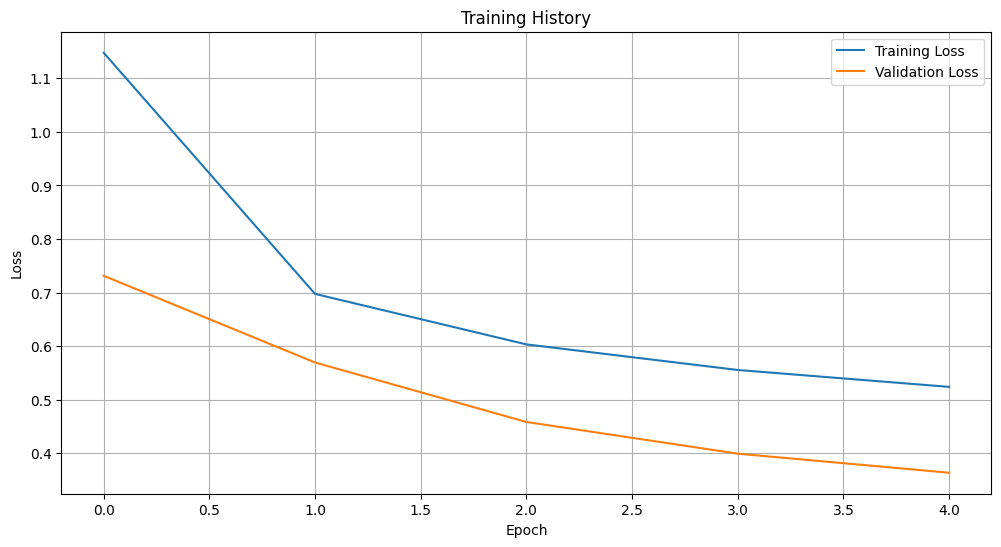

Pipeline test completed successfully

All tests passed successfully!


In [39]:
try:
    success = test_model_pipeline()
    if success:
        print("\nAll tests passed successfully!")
except Exception as e:
    print("\nTest failed with error:")
    print(str(e))